In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import math
import pickle
import os

from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
import gensim

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

# Data

## Loading data

In [3]:
#we'll load all our datasets
#we'll perform general analysis on train dataset
train = pd.read_csv('data/raw/train.csv')
cv = pd.read_csv('data/raw/cv.csv')
test = pd.read_csv('data/raw/test.csv')

In [4]:
train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,But they'll have all those reviews!,RoguishPoppet,ProductTesting,0,-1,-1,2016-11,2016-11-01 02:04:59,"The dumb thing is, they are risking their sell..."
1,1,wow it is totally unreasonable to assume that ...,pb2crazy,politics,2,-1,-1,2016-11,2016-11-01 02:42:11,Clinton campaign accuses FBI of 'blatant doubl...
2,1,Ho ho ho... But Melania said that there is no ...,pb2crazy,politics,8,-1,-1,2016-10,2016-10-18 16:20:53,Anyone else think that it was interesting the ...
3,1,I can't wait until @potus starts a twitter war...,kitduncan,politics,3,-1,-1,2016-11,2016-11-01 03:22:33,Here's what happens when Obama gives up his Tw...
4,1,gotta love the teachers who give exams on the ...,DEP61,CFBOffTopic,3,-1,-1,2016-11,2016-11-01 03:30:11,Monday night Drinking thread Brought to You by...


In [5]:
train.shape

(800000, 10)

We've loaded our balanced data set with 800K points.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           800000 non-null  int64 
 1   comment         799972 non-null  object
 2   author          800000 non-null  object
 3   subreddit       800000 non-null  object
 4   score           800000 non-null  int64 
 5   ups             800000 non-null  int64 
 6   downs           800000 non-null  int64 
 7   date            800000 non-null  object
 8   created_utc     800000 non-null  object
 9   parent_comment  800000 non-null  object
dtypes: int64(4), object(6)
memory usage: 61.0+ MB


## Columns

We have a total of 10 columns in our dataset:
- <b>label:</b> The output label of each datapoint. 0 => not-sarcastic, 1 => sarcastic
- <b>comment:</b> The raw text of comment
- <b>author:</b> Author or username by which the comment was posted
- <b>subreddit:</b> Subreddit under which the comment was posted
- <b>score/ups/downs:</b> score given by community to comment
- <b>date/created_utc:</b> date on which the comment was posted in different formats
- <b>parent_comment:</b> parent of this comment in Reddit tree

## Exploratory Data Analysis (EDA)

In [7]:
train['label'].value_counts()

1    400000
0    400000
Name: label, dtype: int64

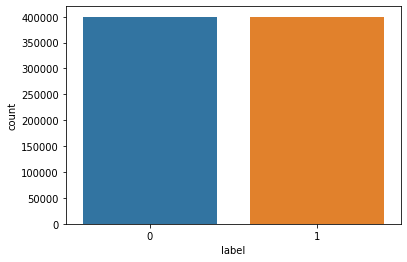

In [8]:
sns.countplot(x='label', data=train)

We've a total of ~800K data points with both positive and negative class having same number of points (perfectly balanced dataset)

In [9]:
len(train['subreddit'].unique())

13432

In [10]:
train[train['label'] == 1]['subreddit'].value_counts()[:20]

AskReddit          20088
politics           18080
worldnews          12470
pcmasterrace        9671
leagueoflegends     9333
news                8495
GlobalOffensive     7251
nba                 5831
nfl                 5815
todayilearned       5514
pics                4984
funny               4853
AdviceAnimals       4614
The_Donald          4458
videos              4350
TumblrInAction      3861
hockey              3797
gaming              3570
soccer              3361
CFB                 2730
Name: subreddit, dtype: int64

- There are a total of 13432 different subreddits in our dataset. 
- Top 20 subreddits having sarcastic comments include AskReddit, politics, worldnews, etc.

In [11]:
len(train['author'].unique())

228956

In [12]:
train[train['label'] == 1]['author'].value_counts()[:20]

Biffingston          219
pokemon_fetish       213
ShyBiDude89          187
NeonDisease          179
ivsciguy             161
mad-n-fla            150
mindlessrabble       129
sleaze_bag_alert     125
Chaoslab             123
JumpingJazzJam        97
DownvoteDaemon        94
EMINEM_4Evah          92
richardleosimones     84
InFearn0              82
TouchMeHerePls        79
kurisu7885            77
tau-lepton            76
Canada_girl           72
ozric101              72
hookyboysb            71
Name: author, dtype: int64

- We have comments from approx. 228956 different users in our dataset
- Top 20 users having sarcastic comments include Biffingston, pokemon_fetish, ShyBiDude89, etc.

In [13]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_font_size = 100, 
                random_state = 17, width=800, height=400)

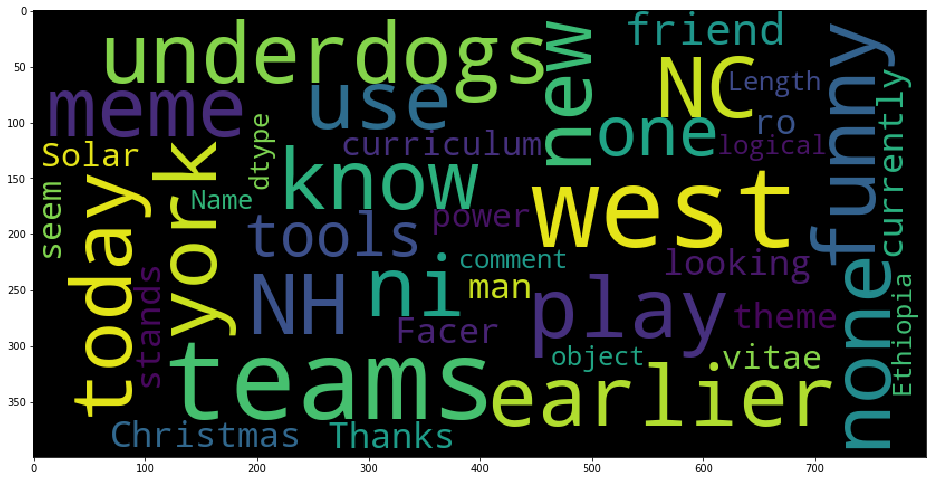

In [14]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 0, 'comment']))
plt.imshow(wordcloud)

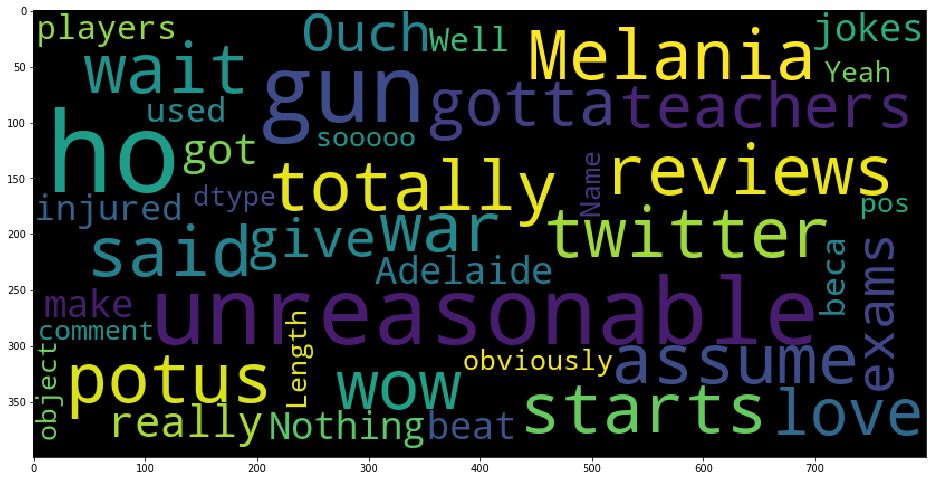

In [15]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train.loc[train['label'] == 1, 'comment']))
plt.imshow(wordcloud)

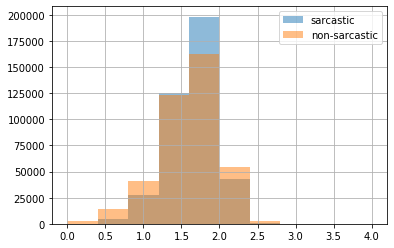

In [16]:
train.loc[train['label'] == 1, 'comment'].str.len().apply(np.log10).hist(label='sarcastic', alpha=.5)
train.loc[train['label'] == 0, 'comment'].str.len().apply(np.log10).hist(label='non-sarcastic', alpha=.5)
plt.legend()

There is alot of overlap in the lenghts of sarcastic/non-sarcastic comments. No clear distinction

## Data Cleaning

We'll use several data cleaning steps to clean our raw data and convert it to well formatted strings which are suitable for ML/DL models. <br>
Data cleaning steps include:
- remove nulls
- Removal of URLs/links
- Removal of HTML tags
- Conversion to lower case strings
- Remove words with numbers
- Remove punctuations
- Removal of whitespaces
- Decontraction of words
- Removal of emojis/emoticons

References:

1. https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
2. https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
3. https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py

In [17]:
#downloaded this dict from above reference
from emo_unicode import EMOTICONS

In [18]:
def removeLinks(text):
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return text

def removeHTMLTags(text):
    text = re.sub(r'<.*?>', '', text, flags=re.MULTILINE)
    return text

def convertToLowerCase(text):
    return text.lower()

def removeWordsWithNumbers(text):
    return re.sub(r'\S*\d\S*', '', text).strip()

def removePuctuations(text):
    return re.sub(r'[^A-Za-z0-9]+', ' ', text)

def removeWhiteSpaces(text):
    return text.strip()

def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [19]:
def clean_data(text):
    
    text = str(text)
    text = removeLinks(text)
    text = removeHTMLTags(text)
    text = convertToLowerCase(text)
    text = removeWordsWithNumbers(text)
    text = removeWhiteSpaces(text)
    text = decontracted(text)
    text = removePuctuations(text)
    text = remove_emoji(text)
    text = remove_emoticons(text)
    text = text.strip()
    
    return text

In [20]:
cleaned_train = train.dropna(how='any', axis=0)
cleaned_train['comment'] = cleaned_train['comment'].apply(clean_data)
cleaned_train['author'] = cleaned_train['author'].apply(removeWhiteSpaces)

cleaned_cv = cv.dropna(how='any', axis=0)
cleaned_cv['comment'] = cleaned_cv['comment'].apply(clean_data)
cleaned_cv['author'] = cleaned_cv['author'].apply(removeWhiteSpaces)

cleaned_test = test.dropna(how='any', axis=0)
cleaned_test['comment'] = cleaned_test['comment'].apply(clean_data)
cleaned_test['author'] = cleaned_test['author'].apply(removeWhiteSpaces)

In [21]:
#testing
train['comment'].iloc[66]

'Because anecdotes mean anything and being gay/trans is evil'

In [22]:
#testing
cleaned_train['comment'].iloc[66]

'because anecdotes mean anything and being gay trans is evil'

In [24]:
cleaned_train['comment'] = cleaned_train['comment'].astype(str)
cleaned_cv['comment'] = cleaned_cv['comment'].astype(str)
cleaned_test['comment'] = cleaned_test['comment'].astype(str)

cleaned_train['author'] = cleaned_train['author'].astype(str)
cleaned_cv['author'] = cleaned_cv['author'].astype(str)
cleaned_test['author'] = cleaned_test['author'].astype(str)

In [25]:
cleaned_train.to_csv('data/clean/train.csv', index=None)
cleaned_cv.to_csv('data/clean/cv.csv', index=None)
cleaned_test.to_csv('data/clean/test.csv', index=None)